In [1]:
# !pip install conllu stanza scikit-learn nltk

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# IMPORT DAN PERSIAPAN

import nltk
from conllu import parse_incr
import random
import stanza
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction import DictVectorizer

# Pembuatan dan Evaluasi POS Tagger untuk Bahasa Inggris

**✏️ Rencana Pipeline:**

1️⃣ Dataset Preparation:

- Dataset: UD English EWT, .conllu, gunakan conllu untuk parse.
- Gunakan UPOS.
- Split: gunakan train, dev, test resmi dari UD untuk konsistensi riset.

2️⃣ Explorasi Dataset:

- Distribusi panjang kalimat.
- Distribusi tag.
- Contoh kalimat dan tagging.

3️⃣ Model Training:

- HMM POS Tagger (NLTK).
- Logistic Regression POS Tagger (Scikit-Learn) sebagai baseline.
- Fitur: token lowercased, suffix, is_digit, is_capitalized.

4️⃣ Evaluasi:

- Accuracy keseluruhan.
- Confusion Matrix.
- Per-tag Precision, Recall, F1 (sklearn classification_report).

5️⃣ Prediction Testing:

- Pilih 1 kalimat testing (bebas, misal headline berita).
- Predict POS tag dengan HMM dan Logistic Regression.
- Bandingkan hasil dengan stanza untuk baseline SOTA.

6️⃣ Visualisasi:

- Visualisasi POS tagging:
- Gunakan matplotlib untuk menampilkan POS tag secara inline.
- Atau ubah output ke format dependency parse dummy untuk divisualisasikan dengan displaCy.
- Atau gunakan graphviz untuk visual interpretabilitas custom.
- Interpretasikan hasil (kenapa model gagal/sukses di token tertentu).

7️⃣ Bonus: NER + Chunking dengan stanza:

- Gunakan kalimat yang sama untuk predict NER.
- Predict dependency parse + noun chunks.

🚩 4️⃣ Hal yang perlu disiapkan
✅ Format dataset .conllu
✅ Library: conllu, nltk, sklearn, stanza, matplotlib
✅ Struktur folder:

```bash
/project
    |- en_ewt-ud-train.conllu
    |- en_ewt-ud-dev.conllu
    |- en_ewt-ud-test.conllu
    |- notebook.ipynb
```

In [4]:
# LOAD UD ENGLISH EWT

# Fungsi load conllu jadi tagged_sents
def load_ud_conllu(filepath):
    sentences = []
    with open(filepath, "r", encoding="utf-8") as f:
        for tokenlist in parse_incr(f):
            sent = [(token['form'], token['upos']) for token in tokenlist if token['form'] is not None]
            sentences.append(sent)
    return sentences

train_sents = load_ud_conllu("en_ewt-ud-train.conllu")
dev_sents = load_ud_conllu("en_ewt-ud-dev.conllu")
test_sents = load_ud_conllu("en_ewt-ud-test.conllu")

Contoh kalimat:
[('Fri.', 'PROPN'), ('Sept.', 'PROPN'), ('29', 'NUM'), ('-', 'PUNCT'), ('Paris', 'PROPN'), ('(', 'PUNCT'), ('Giverny', 'PROPN'), ('-', 'PUNCT'), ("Monet's", '_'), ('Monet', 'PROPN'), ("'s", 'PART'), ('gardens', 'NOUN'), ('-', 'PUNCT'), ('3', 'NUM'), ('/', 'SYM'), ('4', 'NUM'), ('day', 'NOUN'), ('side', 'NOUN'), ('trip', 'NOUN'), (')', 'PUNCT')]


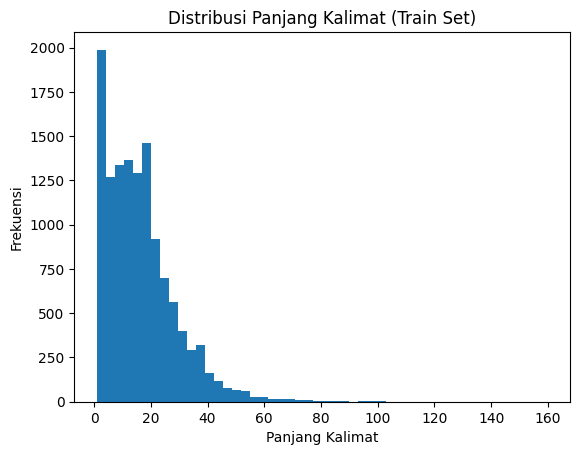

Tag unik: {'NOUN', 'SYM', 'ADJ', 'X', 'PRON', 'VERB', 'AUX', 'PUNCT', 'PROPN', 'SCONJ', 'ADV', 'INTJ', 'DET', 'ADP', '_', 'PART', 'NUM', 'CCONJ'}
Distribusi tag (Top 10): [('NOUN', 34751), ('PUNCT', 23596), ('VERB', 22603), ('PRON', 18677), ('ADP', 17748), ('DET', 16299), ('ADJ', 13138), ('AUX', 12818), ('PROPN', 12620), ('ADV', 10167)]


In [5]:
# EKSPLORASI DATASET

# Satu contoh kalimat
print("Contoh kalimat:")
print(random.choice(train_sents))

# Distribusi panjang kalimat
sent_lengths = [len(sent) for sent in train_sents]
plt.hist(sent_lengths, bins=50)
plt.title("Distribusi Panjang Kalimat (Train Set)")
plt.xlabel("Panjang Kalimat")
plt.ylabel("Frekuensi")
plt.show()

# Tag unik
tags = [tag for sent in train_sents for (_, tag) in sent]
print("Tag unik:", set(tags))
print("Distribusi tag (Top 10):", Counter(tags).most_common(10))


In [6]:
# TRAINING HMM POS TAGGER (NLTK)

from nltk.tag.hmm import HiddenMarkovModelTrainer

# Format data untuk HMM
trainer = HiddenMarkovModelTrainer()
hmm_tagger = trainer.train_supervised(train_sents)

# Evaluasi di dev
hmm_accuracy = hmm_tagger.evaluate(dev_sents)
print(f"HMM Accuracy (dev): {hmm_accuracy:.4f}")


HMM Accuracy (dev): 0.5737


In [7]:
# TRAINING LOGISTIC REGRESSION POS TAGGER (scikit-learn)

# Feature Extractor
def word2features(sent, i):
    word = sent[i][0]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
        })
    else:
        features['EOS'] = True

    return features

def prepare_data(sents):
    X, y = [], []
    for sent in sents:
        for i in range(len(sent)):
            X.append(word2features(sent, i))
            y.append(sent[i][1])
    return X, y

X_train, y_train = prepare_data(train_sents)
X_dev, y_dev = prepare_data(dev_sents)


In [8]:
# Vectorizer & Model Training
vec = DictVectorizer(sparse=True)
X_train_vec = vec.fit_transform(X_train)
X_dev_vec = vec.transform(X_dev)

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train_vec, y_train)

y_pred_dev = logreg.predict(X_dev_vec)
logreg_acc = accuracy_score(y_dev, y_pred_dev)
print(f"Logistic Regression Accuracy (dev): {logreg_acc:.4f}")


Logistic Regression Accuracy (dev): 0.9324


In [9]:
# EVALUASI MODEL

print("\nClassification Report (dev):")
print(classification_report(y_dev, y_pred_dev))

print("\nConfusion Matrix Sample (first 5 labels):")
labels = list(set(y_dev))
cm = confusion_matrix(y_dev, y_pred_dev, labels=labels)
print("Labels:", labels[:5])
print(cm[:5,:5])



Classification Report (dev):
              precision    recall  f1-score   support

         ADJ       0.91      0.86      0.89      1865
         ADP       0.92      0.96      0.94      2040
         ADV       0.92      0.85      0.88      1231
         AUX       0.97      0.98      0.98      1567
       CCONJ       0.99      0.99      0.99       779
         DET       0.97      0.99      0.98      1900
        INTJ       0.92      0.63      0.75       115
        NOUN       0.88      0.93      0.90      4210
         NUM       0.96      0.93      0.95       383
        PART       0.93      0.99      0.96       647
        PRON       0.98      0.98      0.98      2225
       PROPN       0.85      0.85      0.85      1867
       PUNCT       0.99      0.99      0.99      3075
       SCONJ       0.89      0.74      0.81       397
         SYM       0.87      0.77      0.82        81
        VERB       0.93      0.93      0.93      2710
           X       0.40      0.07      0.12        

In [10]:
# Init Stanza
# stanza.download('en')

In [11]:
# BANDINGKAN 1 KALIMAT DENGAN STANZA

nlp = stanza.Pipeline('en', processors='tokenize,pos,ner')

# Pilih 1 kalimat
test_sentence = "Natural language processing is fascinating."
tokens = test_sentence.split()

# Predict dengan HMM
hmm_tags = hmm_tagger.tag(tokens)

# Predict dengan Logistic Regression
test_feats = [word2features([(w, '') for w in tokens], i) for i in range(len(tokens))]
X_test_vec = vec.transform(test_feats)
logreg_tags = logreg.predict(X_test_vec)

# Predict dengan Stanza
doc = nlp(test_sentence)
stanza_tags = [(word.text, word.upos) for sent in doc.sentences for word in sent.words]

print("\nKalimat:", test_sentence)
print("\nHMM:", hmm_tags)
clean_logreg_tags = [str(tag) for tag in logreg_tags]
print("LogReg:", list(zip(tokens, clean_logreg_tags)))
print("Stanza:", stanza_tags)


2025-07-03 01:08:19 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-07-03 01:08:19 INFO: Downloaded file to C:\Users\hafid\stanza_resources\resources.json
2025-07-03 01:08:19 WARNING: Language en package default expects mwt, which has been added
2025-07-03 01:08:19 INFO: Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| pos       | combined_charlm           |
| ner       | ontonotes-ww-multi_charlm |

2025-07-03 01:08:19 INFO: Using device: cpu
2025-07-03 01:08:19 INFO: Loading: tokenize
2025-07-03 01:08:21 INFO: Loading: mwt
2025-07-03 01:08:21 INFO: Loading: pos
2025-07-03 01:08:23 INFO: Loading: ner
2025-07-03 01:08:25 INFO: Done loading processors!



Kalimat: Natural language processing is fascinating.

HMM: [('Natural', 'ADJ'), ('language', 'NOUN'), ('processing', 'NOUN'), ('is', 'AUX'), ('fascinating.', 'PROPN')]
LogReg: [('Natural', 'ADJ'), ('language', 'NOUN'), ('processing', 'NOUN'), ('is', 'AUX'), ('fascinating.', 'PUNCT')]
Stanza: [('Natural', 'ADJ'), ('language', 'NOUN'), ('processing', 'NOUN'), ('is', 'AUX'), ('fascinating', 'ADJ'), ('.', 'PUNCT')]


In [12]:
# Pakai spaCy en_core_web_sm
# !python -m spacy download en_core_web_sm

In [16]:
# VISUALISASI displaCy

import spacy
from spacy import displacy

nlp_spacy = spacy.load('en_core_web_sm')

doc = nlp_spacy("Apple is planning to open a new store in San Francisco next year.")

# Visualisasi dengan displaCy
displacy.render(doc, style="dep", jupyter=True, options={'compact': True})


In [14]:
# BONUS: NER DENGAN spaCy

import spacy
from spacy import displacy

# Load spaCy pipeline
nlp = spacy.load("en_core_web_sm")

# Kalimat contoh
sentence = "Apple is planning to open a new store in San Francisco next year."

# Process kalimat
doc = nlp(sentence)

# --- Visualisasi NER ---
print("🔹 Visualisasi NER:")
displacy.render(doc, style="ent", jupyter=True)

🔹 Visualisasi NER:
